In [43]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from yellowbrick.regressor import ResidualsPlot
import plotly.graph_objects as go
#FB prophet
from fbprophet import Prophet
from datetime import date, time, timedelta, datetime

In [44]:
#read in the data frames
accident_df = pd.read_csv('accident_df.csv')
#read in the traffic volume dataframe
volume_df = pd.read_csv('final_volume_counts.csv')

/Users/gene/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



# Accident data

In [45]:
accident_df.head()

,datetime,date,time,borough,zip_code,latitude,longitude,location,on_street_name,cross_street_name,...,contributing_factor_vehicle_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,unique_key,vehicle_type_code_1,vehicle_type_code_2,vehicle_type_code_3,vehicle_type_code_4,vehicle_type_code_5,datetime.1
0,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,MANHATTAN,10010,40.737885,-73.98091,"(40.737885, -73.98091)",2 AVENUE,EAST 23 STREET,...,NaN,NaN,NaN,4116367,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16 00:00:00
1,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,QUEENS,11354,40.762756,-73.82261,"(40.762756, -73.82261)",PARSONS BOULEVARD,38 AVENUE,...,NaN,NaN,NaN,4115878,Sedan,Box Truck,NaN,NaN,NaN,2019-04-16 00:00:00
2,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,QUEENS,11367,40.729404,-73.82282,"(40.729404, -73.82282)",NaN,NaN,...,NaN,NaN,NaN,4115808,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,2019-04-16 00:00:00
3,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,QUEENS,11413,40.665485,-73.75374,"(40.665485, -73.75374)",SOUTH CONDUIT AVENUE,224 STREET,...,NaN,NaN,NaN,4115916,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,2019-04-16 00:00:00
4,2019-04-16 00:00:00,2019-04-16 00:00:00,0:00,NaN,NaN,40.810173,-73.95117,"(40.810173, -73.95117)",WEST 125 STREET,NaN,...,NaN,NaN,NaN,4116309,Station Wagon/Sport Utility Vehicle,Taxi,NaN,NaN,NaN,2019-04-16 00:00:00


In [46]:
accident_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1293105 entries, 0 to 1293104
Data columns (total 31 columns):
datetime                         1293105 non-null object
date                             1293105 non-null object
time                             1293105 non-null object
borough                          1010383 non-null object
zip_code                         1010225 non-null object
latitude                         1293105 non-null float64
longitude                        1293105 non-null float64
location                         1293105 non-null object
on_street_name                   1060568 non-null object
cross_street_name                887188 non-null object
off_street_name                  170677 non-null object
number_of_persons_injured        1293090 non-null float64
number_of_persons_killed         1293077 non-null float64
number_of_pedestrians_injured    1293105 non-null int64
number_of_pedestrians_killed     1293105 non-null int64
number_of_cyclist_injured       

Many features were imported as the generic 'object' type. First, set the inde

In [47]:
accident_df = accident_df.set_index(pd.DatetimeIndex(accident_df['datetime']))

In [48]:
accident_hourly_df = pd.DataFrame(accident_df['date'].resample('H').count())
accident_hourly_df.head()

,date
datetime,
2012-07-01 00:00:00,15
2012-07-01 01:00:00,11
2012-07-01 02:00:00,14
2012-07-01 03:00:00,17
2012-07-01 04:00:00,7


In [49]:
accident_hourly_df['day_of_week'] = accident_hourly_df.index.dayofweek
accident_hourly_df.head()

,date,day_of_week
datetime,,
2012-07-01 00:00:00,15,6
2012-07-01 01:00:00,11,6
2012-07-01 02:00:00,14,6
2012-07-01 03:00:00,17,6
2012-07-01 04:00:00,7,6


In [50]:
accident_hourly_df.reset_index(level=0, inplace=True)
accident_hourly_df = accident_hourly_df.rename(columns={'date':'accidents'})
accident_hourly_df.head()


,datetime,accidents,day_of_week
0,2012-07-01 00:00:00,15,6
1,2012-07-01 01:00:00,11,6
2,2012-07-01 02:00:00,14,6
3,2012-07-01 03:00:00,17,6
4,2012-07-01 04:00:00,7,6


In [51]:
mean_accident_hour_df = pd.DataFrame(accident_hourly_df['accidents'].groupby([accident_hourly_df['day_of_week'], \
                                accident_hourly_df['datetime']]).mean())
mean_accident_hour_df.head()

accidents
day_of_week datetime                      
0           2012-07-02 00:00:00         14
            2012-07-02 01:00:00         11
            2012-07-02 02:00:00          5
            2012-07-02 03:00:00          3
            2012-07-02 04:00:00          2

# Volume data

In [52]:
volume_df = volume_df.rename(columns={'count':'volume'})
volume_df['datetime'] = volume_df['datetime'].astype('datetime64')
volume_df.head()

,datetime,date,time,volume
0,2014-09-13 00:00:00,2014-09-13,00:00:00,22709
1,2014-09-13 01:00:00,2014-09-13,01:00:00,16322
2,2014-09-13 02:00:00,2014-09-13,02:00:00,12008
3,2014-09-13 03:00:00,2014-09-13,03:00:00,9937
4,2014-09-13 04:00:00,2014-09-13,04:00:00,11198


In [53]:
#Visualizing overlap of data
#perform outer join to keep all  data. match on datetime.
overlap_vol_df = volume_df[['date', 'time', 'volume']].copy()
overlap_vol_df['vol_present'] = np.where(overlap_vol_df['volume'] >=5, 1, 0)

In [54]:
len(overlap_vol_df), overlap_vol_df.vol_present.sum()

(7944, 7810)

In [55]:
overlap_vol_df.tail()

,date,time,volume,vol_present
7939,2018-04-15,19:00:00,25500,1
7940,2018-04-15,20:00:00,22073,1
7941,2018-04-15,21:00:00,18295,1
7942,2018-04-15,22:00:00,14946,1
7943,2018-04-15,23:00:00,24938,1


# Joining Data

In [56]:
accident_hourly_df.head()

,datetime,accidents,day_of_week
0,2012-07-01 00:00:00,15,6
1,2012-07-01 01:00:00,11,6
2,2012-07-01 02:00:00,14,6
3,2012-07-01 03:00:00,17,6
4,2012-07-01 04:00:00,7,6


In [57]:
#perform inner join to keep only overlapping data. match on datetime.
accident_merge = pd.merge(volume_df,
                         accident_hourly_df[['accidents']],
                            left_on=volume_df['datetime'],
                            right_on=accident_hourly_df['datetime'],
                            how='inner')

In [58]:
accident_merge.head()

,key_0,datetime,date,time,volume,accidents
0,2014-09-13 00:00:00,2014-09-13 00:00:00,2014-09-13,00:00:00,22709,17
1,2014-09-13 01:00:00,2014-09-13 01:00:00,2014-09-13,01:00:00,16322,21
2,2014-09-13 02:00:00,2014-09-13 02:00:00,2014-09-13,02:00:00,12008,10
3,2014-09-13 03:00:00,2014-09-13 03:00:00,2014-09-13,03:00:00,9937,7
4,2014-09-13 04:00:00,2014-09-13 04:00:00,2014-09-13,04:00:00,11198,15


In [59]:
#check lengths
len_accident_merge = len(accident_merge)
len_vol = len(volume_df)
len_accident = len(accident_hourly_df)
print(f'Length of accident dataframe: {len_accident}\nLength of volume dataframe: {len_vol}\
\nLength of merged dataframe: {len_accident_merge}')

Length of accident dataframe: 59544
Length of volume dataframe: 7944
Length of merged dataframe: 7944


In [60]:
#Select columns to keep in final df - want date and time so can split time into dummy variables
accident_reg_df = accident_merge[['volume', 'date', 'time', 'accidents']]
merged_by_hour = accident_reg_df.copy()
accident_reg_df.head()

,volume,date,time,accidents
0,22709,2014-09-13,00:00:00,17
1,16322,2014-09-13,01:00:00,21
2,12008,2014-09-13,02:00:00,10
3,9937,2014-09-13,03:00:00,7
4,11198,2014-09-13,04:00:00,15


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0, 0.5, 'Accidents')

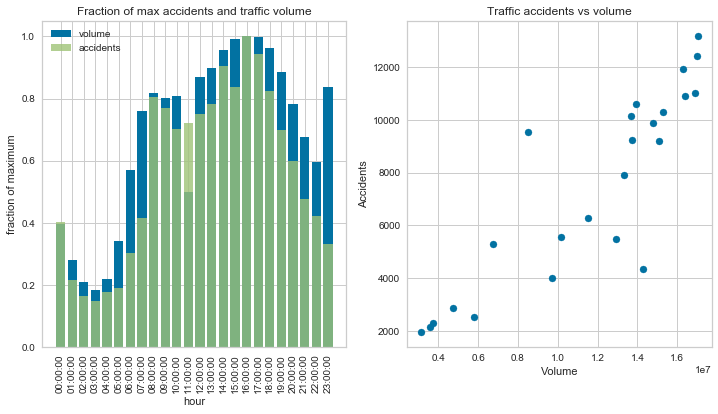

In [61]:
#look at both volume and accidents summed for each hour of the day. Divide by max to
# get faction max value so can see if have same general trend
summed_by_hour = merged_by_hour.groupby(['time']).sum()

#plt.scatter(summed_by_hour.volume, summed_by_hour.accidents)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(summed_by_hour.index, summed_by_hour.volume/summed_by_hour.volume.max(), label='volume')
plt.bar(summed_by_hour.index, summed_by_hour.accidents/summed_by_hour.accidents.max(), alpha=0.8, \
        label='accidents')
plt.title('Fraction of max accidents and traffic volume')
plt.xlabel('hour')
plt.ylabel('fraction of maximum')
_ = plt.xticks(rotation=90)
plt.legend()
plt.subplot(1,2,2)
_ = plt.scatter(summed_by_hour.volume, summed_by_hour.accidents)
plt.title('Traffic accidents vs volume')
plt.xlabel('Volume')
plt.ylabel('Accidents')

In [62]:
dum = pd.get_dummies(accident_reg_df['time'])
accident_reg_df = pd.concat([accident_reg_df, dum], axis=1) 
accident_reg_df = accident_reg_df.drop('time', axis=1)

In [63]:
accident_reg_df.date = accident_reg_df.date.astype('datetime64')
accident_reg_df.head()
#accident_reg_df.info()

,volume,date,accidents,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,22709,2014-09-13,17,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16322,2014-09-13,21,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12008,2014-09-13,10,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9937,2014-09-13,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11198,2014-09-13,15,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
#create timedelta column
min_date = accident_reg_df.date.min()
accident_reg_df['date'] = (accident_reg_df['date'] - \
                                           min_date).dt.days.astype(int)
accident_reg_df.head()

,volume,date,accidents,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,22709,0,17,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16322,0,21,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12008,0,10,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9937,0,7,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11198,0,15,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#  Linear Regression Model
1. volume vs accident by day
2. volume vs accident by hour by day
3. volume vs accident by hour no day
4. volume vs accident

In [65]:
accident_reg_df.head()
vol_date_acc_df = accident_reg_df[['volume', 'date', 'accidents']]
vol_date_acc_df.head()

,volume,date,accidents
0,22709,0,17
1,16322,0,21
2,12008,0,10
3,9937,0,7
4,11198,0,15


In [66]:
X1 = vol_date_acc_df.drop('accidents', axis=1)
y1 = vol_date_acc_df[['accidents']]

In [67]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=27)

In [68]:
reg = LinearRegression()
reg.fit(X1_train, y1_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [69]:
cv_results = cross_val_score(reg, X1_train, y1_train, cv=5)
cv_results

array([0.11457365, 0.0831986 , 0.12028851, 0.10631054, 0.09329401])

In [70]:
X1_score = reg.score(X1_train, y1_train)

Will want to scale features for linear regression.


In [71]:
#We want to predict number of accidents, so remove that column from the df
y2 = accident_reg_df[['accidents']]
X2 = accident_reg_df.drop('accidents', axis=1)

#scaler = StandardScaler()
#names= X1.columns
#X1 = scaler.fit_transform(X)

In [72]:
X2.head()

,volume,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
0,22709,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,16322,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12008,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9937,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,11198,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
#Split the data
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=27)

In [74]:
reg = LinearRegression()
reg.fit(X2_train,y2_train)
cv_results = cross_val_score(reg, X2_train, y2_train, cv=5)
cv_results

array([0.63406032, 0.63730188, 0.6554138 , 0.63480233, 0.65504819])

In [75]:
X2_score = reg.score(X2_test, y2_test)

In [76]:
print(f'Scores: X1:{X1_score}, X2:{X2_score}')

Scores: X1:0.10573125225216173, X2:0.6568088735363293


0.6568088735363293

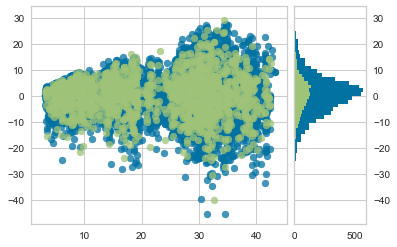

In [77]:
#Residual plot
#plt.scatter(reg.predict(np.array(X2_test)), reg.predict(np.array(X2_test)) - np.array(y2_test), \
#                                                       c='green', s = 40)
#plt.hlines(y=0, xmin=0, xmax=50)
#plt.title('Residual plot')
#plt.ylabel('Residual')

# Instantiate the linear model and visualizer
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(np.array(X2_train), np.array(y2_train))  # Fit the training data to the visualizer
visualizer.score(np.array(X2_test), np.array(y2_test))  # Evaluate the model on the test data
#ResidualsPlot.show()                 # Finalize and render the figure

While there appears to be some heteroscedasticity in the above residual plot, the values appear quite normal around 0

In [78]:
X2_train.head()

,volume,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,14:00:00,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00
7598,8481,1274,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4462,9896,765,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7236,7734,1226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3311,9730,435,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
231,46526,9,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


Now that we have established that a linear regression is a suitable model for the traffic accident data, we can perform lasso regularization to select important features of the dataset and shrink the less important ones. This will simplify our model and help us answer the question 'what time of day are you most likely to get into a car accident'.

# Lasso Regression

In [79]:
#scaler = StandardScaler()
#names= X2.columns
#X2 = scaler.fit_transform(X2)

In [82]:
#https://chrisalbon.com/machine_learning/linear_regression/effect_of_alpha_on_lasso_regression/
# Create a function called lasso,
def lasso(alphas):
    '''
    Takes in a list of alphas. Outputs a dataframe containing the coefficients of lasso regressions from each alpha.
    '''
    # Create an empty data frame
    coef = pd.DataFrame()
    
    # Create a column of feature names
    coef['Feature Name'] = X2.columns
    
    # For each alpha value in the list of alpha values,
    for alpha in alphas:
        # Create a lasso regression with that alpha value,
        lasso = Lasso(alpha=alpha)
        lasso.fit(X2, y2) #fit regression
        
        # Create a column name for that alpha value
        column_name = 'Alpha = %f' % alpha

        # Create a column of coefficient values
        coef[column_name] = lasso.coef_
        
    # Return the dataframe 
    return coef

In [83]:
df = pd.DataFrame(lasso([.0001, .25, .5]))
df

,Feature Name,Alpha = 0.000100,Alpha = 0.250000,Alpha = 0.500000
0,volume,0.000019,0.000070,0.000108
1,date,0.004179,0.005127,0.005839
2,00:00:00,-9.453111,-0.927986,-0.000000
3,01:00:00,-16.695991,-7.863160,-0.000000
4,02:00:00,-18.730889,-9.714377,-1.395630
5,03:00:00,-19.331563,-10.248145,-1.879153
6,04:00:00,-18.262614,-9.270656,-0.970349
7,05:00:00,-17.785682,-9.113941,-1.054111
8,06:00:00,-13.542419,-5.471910,-0.000000
9,07:00:00,-9.273115,-1.700582,-0.000000


Text(0, 0.5, 'Alpha value')

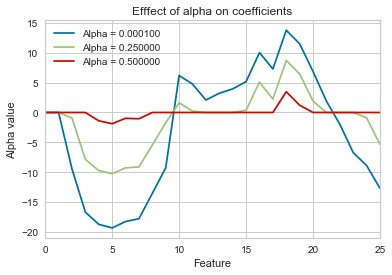

In [84]:
df.plot()
plt.title('Efffect of alpha on coefficients')
plt.xlabel('Feature')
plt.ylabel('Alpha value')

Regularization shrinks unimportant factors, and leaves us with the most important features for minimizing the loss function. Here we see that negative values for columns 4:7 and positive values for columns 18 and 19.

In [97]:
reg3 = Lasso(alpha=.25)
reg3.fit(X2_train, y2_train)
cv_results = cross_val_score(reg3, X2_train, y2_train, cv=5)
cv_results

array([0.45526341, 0.45583526, 0.48052536, 0.45565887, 0.46174586])

In [98]:
len(y2_train), len(X2_train)

(6355, 6355)

In [ ]:
# Instantiate the linear model and visualizer
#visualizer = ResidualsPlot(reg)

#visualizer.fit(np.array(X2_train.volume).reshape(-1,1), np.array(y2_train))  # Fit the training data to the visualizer
#visualizer.score(np.array(X2_test.volume).reshape(-1,1), np.array(y2_test))  # Evaluate the model on the test data
#visualizer.poof()                 # Draw/show/poof the data            # Draw/show/poof the data

Talked about regression of traffic volume and accidents only without the hourly compnent

# Poisson Regression

In [99]:
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [100]:
#Using the statsmodels GLM class, train the Poisson regression model on the training data set.
poisson_training_results = sm.GLM(y2_train, X2_train, family=sm.families.Poisson()).fit()

In [101]:
#Print the training summary.
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              accidents   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6329
Model Family:                 Poisson   Df Model:                           25
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -24378.
Date:                Sat, 26 Oct 2019   Deviance:                       18950.
Time:                        22:53:06   Pearson chi2:                 1.86e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
volume      7.364e-07   7.04e-08     10.459      0.0

In [102]:
poisson_predictions = poisson_training_results.get_prediction(X2_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

           mean   mean_se  mean_ci_lower  mean_ci_upper
806   33.636118  0.373046      32.912850      34.375280
3169   8.075453  0.171351       7.746498       8.418377
6789  21.134456  0.306390      20.542394      21.743583
2212   6.703629  0.153090       6.410193       7.010497
7547  32.061799  0.381269      31.323167      32.817849
3176  30.483010  0.332752      29.837755      31.142218
2517  19.170963  0.282060      18.626031      19.731839
6014  39.282470  0.412962      38.481362      40.100256
7893  21.599440  0.317785      20.985488      22.231353
3290   6.256494  0.147327       5.974301       6.552016
1725  17.301036  0.253573      16.811112      17.805237
4596  29.983860  0.344164      29.316843      30.666053
4779   6.017739  0.152778       5.725628       6.324753
3966  11.674487  0.207105      11.275545      12.087543
1464  14.457821  0.226530      14.020580      14.908699
7878  13.668050  0.246104      13.194107      14.159017
5205  20.528351  0.301213      19.946393      21

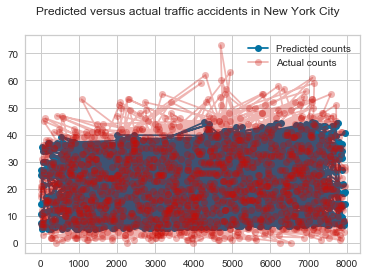

In [103]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y2_test
fig = plt.figure()
fig.suptitle('Predicted versus actual traffic accidents in New York City')
predicted, = plt.plot(X2_test.index, predicted_counts, 'bo-', label='Predicted counts')
actual, = plt.plot(X2_test.index, actual_counts, 'ro-', label='Actual counts', alpha=0.3)
plt.legend(handles=[predicted, actual])
plt.show()

# Negative bionomial regression

In [107]:
#Create new dataframe from X2_train and merge in corresponding accident values from y2_train
X2_bionom = X2_train.copy()
X2_bionom = X2_bionom.merge(y2_train, left_index=True, right_index=True)

In [108]:
X2_bionom.head()

,volume,date,00:00:00,01:00:00,02:00:00,03:00:00,04:00:00,05:00:00,06:00:00,07:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,accidents
7598,8481,1274,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
4462,9896,765,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,10
7236,7734,1226,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,21
3311,9730,435,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,11
231,46526,9,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,36


[39.47734551 16.8224093  32.29484018 ... 15.5794629  15.5644498
  6.06866152]
BB_LAMBDA    0.070431
dtype: float64
                 Generalized Linear Model Regression Results                  
Dep. Variable:              accidents   No. Observations:                 6355
Model:                            GLM   Df Residuals:                     6329
Model Family:        NegativeBinomial   Df Model:                           25
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -21859.
Date:                Sat, 26 Oct 2019   Deviance:                       8307.7
Time:                        23:00:15   Pearson chi2:                 7.95e+03
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------

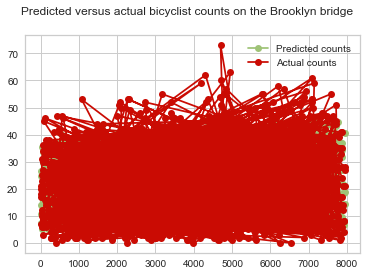

In [109]:

#Assunes that Poisson training has already been completed and saved to poisson_training_results
#print out the fitted rate vector
print(poisson_training_results.mu)

#Add the λ vector as a new column called 'BB_LAMBDA' to the Data Frame of the training data set

X2_bionom['BB_LAMBDA'] = poisson_training_results.mu

#add a derived column called 'AUX_OLS_DEP' to the pandas Data Frame. This new column will store the values of the dependent variable of the OLS regression
X2_bionom['AUX_OLS_DEP'] = X2_bionom.apply(lambda x: ((x['accidents'] - x['BB_LAMBDA'])**2 - x['accidents']) / x['BB_LAMBDA'], axis=1)

#use patsy to form the model specification for the OLSR
ols_expr = """AUX_OLS_DEP ~ BB_LAMBDA - 1"""

#Configure and fit the OLSR model
aux_olsr_results = smf.ols(ols_expr, X2_bionom).fit()

#Print the regression params
print(aux_olsr_results.params)

#train the NB2 model on the training data set
nb2_training_results = sm.GLM(y2_train, X2_train,family=sm.families.NegativeBinomial(alpha=aux_olsr_results.params[0])).fit()

#print the training summary
print(nb2_training_results.summary())

#make some predictions using our trained NB2 model
nb2_predictions = nb2_training_results.get_prediction(X2_test)

#print out the predictions
predictions_summary_frame = nb2_predictions.summary_frame()
print(predictions_summary_frame)

#plot the predicted counts versus the actual counts for the test data
predicted_counts=predictions_summary_frame['mean']
actual_counts = y2_test['accidents']
fig = plt.figure()
fig.suptitle('Predicted versus actual bicyclist counts on the Brooklyn bridge')
predicted, = plt.plot(X2_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X2_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
